In [1]:
#Code adapted from example here: https://medium.com/zama-ai/homomorphic-rnns-with-numpy-and-concrete-ed890402ab86
import hnumpy as hnp
import io
import numpy as np
import pathlib
import pickle
import re
import timeit
import torch
import urllib
import zipfile

In [2]:
with open("embeddings.pickle", "rb") as file:
    embeddings = pickle.load(file)
    embed = lambda tokens: embeddings["data"][[embeddings["indices"][token] for token in tokens], :]

In [3]:
index = embeddings["indices"]["encryption"]
print(index)

11196


In [4]:
embedding = embeddings["data"][index, :]
print(embedding)

[-5.000e-03 -1.992e-01 -4.550e-02  1.454e-01 -1.571e-01 -2.310e-02
  1.353e-01 -1.410e-01 -4.920e-02  1.590e-02  1.834e-01 -1.863e-01
  5.220e-02  4.200e-02 -6.340e-02  1.412e-01 -3.682e-01 -9.100e-02
 -2.147e-01  1.527e-01 -5.660e-01  4.370e-02 -1.274e-01  2.398e-01
  1.387e-01 -8.950e-02  1.634e-01 -1.001e-01  1.094e-01  4.300e-02
 -1.049e-01  1.742e-01 -1.222e-01 -2.710e-02 -1.227e-01  5.100e-02
 -9.210e-02  4.490e-02  6.960e-02  3.200e-02  4.250e-02 -2.030e-02
  1.830e-01  2.036e-01 -8.450e-02  6.350e-02 -6.380e-02  9.720e-02
  1.447e-01 -6.450e-02 -7.830e-02 -8.050e-02 -8.305e-01  1.572e-01
  3.028e-01 -3.560e-02  3.350e-01 -1.540e-01 -1.980e-02  1.585e-01
  1.698e-01 -1.545e-01  3.230e-02 -2.000e-03 -2.580e-01 -5.160e-02
  2.900e-02  8.570e-02  1.540e-02 -1.833e-01 -1.032e-01  1.003e-01
  6.960e-02  8.000e-04 -7.060e-02 -1.465e-01  1.549e-01 -1.060e-01
  1.040e-02  1.298e-01  1.740e-02 -1.158e-01 -1.030e-01 -1.747e-01
 -1.668e-01 -1.496e-01 -6.450e-02  2.748e-01  2.840e-01 -1.840

In [5]:
words_to_ignore = []
for word, index in embeddings["indices"].items():
    embedding = embeddings["data"][index, :]
    if embedding.min() < -1 or embedding.max() > 1:
        words_to_ignore.append(word)
for word in words_to_ignore:
    del embeddings["indices"][word]

In [86]:
def encode(sentence):
    sentence = sentence.strip().lower()
    sentence = re.sub(r"[^\w\s]", ' ', sentence)
    sentence = re.sub(r"\s+", ' ', sentence)
    
    tokens = filter(lambda token: token in embeddings["indices"], sentence.split(' '))
    
    return embed(filter(lambda token: token != "", sentence.split(' ')))

In [7]:
encode("i like cookies").shape

(3, 300)

In [8]:
DATASET_PATHS = ["amazon.txt", "imdb.txt", "yelp.txt"]

DATASET = []
for path in DATASET_PATHS:
    with open(path, "r") as file:
        for line in file:
            [line, orientation] = line.strip().split('\t')
            try:
                DATASET.append((encode(line), float(orientation)))
            except:
                pass

In [9]:
print(DATASET[0])

(array([[-0.0154, -0.002 , -0.0725, ...,  0.1858,  0.105 , -0.0423],
       [-0.0424,  0.007 , -0.1028, ...,  0.2318, -0.01  ,  0.0948],
       [ 0.0156,  0.0752, -0.078 , ...,  0.0882, -0.0882, -0.0096],
       ...,
       [ 0.0242, -0.0265,  0.0822, ...,  0.0831, -0.0466,  0.0315],
       [ 0.0047,  0.0223, -0.0087, ...,  0.1479,  0.1324, -0.0318],
       [-0.0582, -0.1396, -0.045 , ...,  0.0076,  0.0079,  0.0541]]), 0.0)


In [10]:
print(len(DATASET))

2677


In [78]:
HIDDEN_SIZE = 100

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = torch.nn.LSTM(input_size=300, hidden_size=HIDDEN_SIZE)
        self.fc = torch.nn.Linear(HIDDEN_SIZE, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        _, (x, _) = self.lstm(x)
        x = self.fc(x)
        return self.sigmoid(x)

In [79]:
LEARNING_RATE = 0.001
EPOCHS = 10

model = Model()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

model.train()
for i in range(EPOCHS):
    for sentence, score in DATASET:
        x = torch.tensor(sentence.reshape(-1, 1, 300))
        prediction = model(x.float())

        optimizer.zero_grad()
        loss = criterion(prediction, torch.tensor([[[score]]]).float())

        loss.backward()
        optimizer.step()

    print("Epoch", i + 1, "is completed...", flush=True)
model.eval()

Epoch 1 is completed...
Epoch 2 is completed...
Epoch 3 is completed...
Epoch 4 is completed...
Epoch 5 is completed...
Epoch 6 is completed...
Epoch 7 is completed...
Epoch 8 is completed...
Epoch 9 is completed...
Epoch 10 is completed...


Model(
  (lstm): LSTM(300, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
class Inferer:
    def __init__(self, model):
        parameters = list(model.lstm.parameters())

        W_ii, W_if, W_ig, W_io = parameters[0].split(HIDDEN_SIZE)
        W_hi, W_hf, W_hg, W_ho = parameters[1].split(HIDDEN_SIZE)
        b_ii, b_if, b_ig, b_io = parameters[2].split(HIDDEN_SIZE)
        b_hi, b_hf, b_hg, b_ho = parameters[3].split(HIDDEN_SIZE)

        self.W_ii = W_ii.detach().numpy()
        self.b_ii = b_ii.detach().numpy()

        self.W_hi = W_hi.detach().numpy()
        self.b_hi = b_hi.detach().numpy()

        self.W_if = W_if.detach().numpy()
        self.b_if = b_if.detach().numpy()

        self.W_hf = W_hf.detach().numpy()
        self.b_hf = b_hf.detach().numpy()

        self.W_ig = W_ig.detach().numpy()
        self.b_ig = b_ig.detach().numpy()

        self.W_hg = W_hg.detach().numpy()
        self.b_hg = b_hg.detach().numpy()

        self.W_io = W_io.detach().numpy()
        self.b_io = b_io.detach().numpy()

        self.W_ho = W_ho.detach().numpy()
        self.b_ho = b_ho.detach().numpy()

        self.W = model.fc.weight.detach().numpy().T
        self.b = model.fc.bias.detach().numpy()

    def infer(self, x):
        x_t, h_t, c_t = None, np.zeros(HIDDEN_SIZE), np.zeros(HIDDEN_SIZE)
        for i in range(x.shape[0]):
            x_t = x[i]
            _, h_t, c_t = self.lstm_cell(x_t, h_t, c_t)

        r = np.dot(h_t, self.W) + self.b
        return self.sigmoid(r)

    def lstm_cell(self, x_t, h_tm1, c_tm1):
        i_t = self.sigmoid(
            np.dot(self.W_ii, x_t) + self.b_ii + np.dot(self.W_hi, h_tm1) + self.b_hi
        )
        f_t = self.sigmoid(
            np.dot(self.W_if, x_t) + self.b_if + np.dot(self.W_hf, h_tm1) + self.b_hf
        )
        g_t = np.tanh(
            np.dot(self.W_ig, x_t) + self.b_ig + np.dot(self.W_hg, h_tm1) + self.b_hg
        )
        o_t = self.sigmoid(
            np.dot(self.W_io, x_t) + self.b_io + np.dot(self.W_ho, h_tm1) + self.b_ho
        )

        c_t = f_t * c_tm1 + i_t * g_t
        h_t = o_t * np.tanh(c_t)

        return o_t, h_t, c_t

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

In [14]:
SENTENCE_LENGTH_LIMIT = 5

inferer = Inferer(model)
homomorphic_inferer = hnp.compile_fhe(
    inferer.infer,
    {
        "x": hnp.encrypted_ndarray(bounds=(-1, 1), shape=(SENTENCE_LENGTH_LIMIT, 300))
    },
    config=hnp.config.CompilationConfig(
        parameter_optimizer="handselected",
        apply_topological_optimizations=True,
        probabilistic_bounds=6,
    ),
)

context = homomorphic_inferer.create_context()
keys = context.keygen()

operations = homomorphic_inferer.operation_count()
pbses = homomorphic_inferer.pbs_count()

print("\nTarget graph has", operations, "nodes and", pbses, "of them are PBS...")

2024-04-21 02:58:46.118 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling infer into an FHE function
2024-04-21 02:58:46.119 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2024-04-21 02:58:46.289 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2024-04-21 02:58:46.308 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `handselected`
2024-04-21 02:58:48.465 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2024-04-21 02:58:48.496 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2024-04-21 02:58:48.519 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2024-04-21 02:58:48.534 | INFO     | hnumpy.client:keygen:28 - Creating 0 keyswitching key(s) and 1 bootstrapping key(s). This should take approximately 30 seconds (0.5 minutes)
2024-04-21 03:04:43.430 | DEBUG    | hnumpy.client:keygen:42 - Key creation time took 354.89


Target graph has 389 nodes and 91 of them are PBS...


In [15]:
def evaluate(sentence):
    try:
        embedded = encode(sentence)
    except KeyError as error:
        print("! the word", error, "is unknown")
        return

    if embedded.shape[0] > SENTENCE_LENGTH_LIMIT:
        print(f"! the sentence should not contain more than {SENTENCE_LENGTH_LIMIT} tokens")
        return

    padded = np.zeros((SENTENCE_LENGTH_LIMIT, 300))
    padded[SENTENCE_LENGTH_LIMIT - embedded.shape[0]:, :] = embedded

    original = model(torch.tensor(padded.reshape((-1, 1, 300))).float()).detach().numpy()[0, 0, 0]
    simulated = homomorphic_inferer.simulate(padded)[0]

    start = timeit.default_timer()

    actual = homomorphic_inferer.simulate(padded)[0]
    end = timeit.default_timer()

    if actual < 0.35:
        print("- the sentence was negative", end=' ')
    elif actual > 0.65:
        print("+ the sentence was positive", end=' ')
    else:
        print("~ the sentence was neutral", end=' ')

    print(
        f"("
        f"original: {original * 100:.2f}%, "
        f"simulated: {simulated * 100:.2f}%, "
        f"actual: {actual * 100:.2f}%, "
        f"difference: {np.abs(original - actual) * 100:.2f}%, "
        f"took: {end - start:.3f} seconds"
        f")"
    )
     

In [117]:
import pandas as pd
import numpy as np
import timeit

restaurant_reviews_df = pd.read_csv('restaurant_reviews.csv')

prediction_stats_simulated = [0, 0, 0, 0]  
prediction_stats_original = [0, 0, 0, 0]  
difference_total = 0
time_total = 0

def evaluate(sentence, actual_rating):
    global difference_total, time_total
    
    try:
        embedded = encode(sentence)
    except KeyError as error:
        return

    if embedded.shape[0] > SENTENCE_LENGTH_LIMIT:
        embedded = embedded[:SENTENCE_LENGTH_LIMIT]

    padded = np.zeros((SENTENCE_LENGTH_LIMIT, 300))
    padded[SENTENCE_LENGTH_LIMIT - embedded.shape[0]:, :] = embedded

    simulated = homomorphic_inferer.simulate(padded)[0]
    if simulated < 0.5:
        predicted_sentiment_simulated = 1
    else:
        predicted_sentiment_simulated = 5
    
    start = timeit.default_timer()
    original = model(torch.tensor(padded.reshape((-1, 1, 300))).float()).detach().numpy()[0, 0, 0]
    end = timeit.default_timer()
    
    if original < 0.5:
        predicted_sentiment_original = 1
    else:
        predicted_sentiment_original = 5
    
    if predicted_sentiment_simulated == 1:
        if actual_rating in [1, 2, 3]:
            prediction_stats_simulated[0] += 1  
        else:
            prediction_stats_simulated[1] += 1  
    else:
        if actual_rating in [4, 5]:
            prediction_stats_simulated[2] += 1  
        else:
            prediction_stats_simulated[3] += 1  
    
    if predicted_sentiment_original == 1:
        if actual_rating in [1, 2, 3]:
            prediction_stats_original[0] += 1  
        else:
            prediction_stats_original[1] += 1  
    else:
        if actual_rating in [4, 5]:
            prediction_stats_original[2] += 1  
        else:
            prediction_stats_original[3] += 1  
    
    difference_total += np.abs(original - simulated) * 100
    time_total += end - start
        
for index, row in restaurant_reviews_df.head(500).iterrows():
    text = row['Review']
    actual_rating = int(row['Rating'])
    
    evaluate(text, actual_rating)

total_simulated = sum(prediction_stats_simulated)
total_original = sum(prediction_stats_original)

accuracy_rate_simulated = (prediction_stats_simulated[0] + prediction_stats_simulated[2]) / total_simulated
accuracy_rate_original = (prediction_stats_original[0] + prediction_stats_original[2]) / total_original
average_difference = difference_total / total_simulated
average_time = time_total / total_simulated

print("Statistics for Simulated Model:")
print(f"Accuracy rate: {accuracy_rate_simulated * 100:.2f}%")
print(f"True Positives: {prediction_stats_simulated[0]}")
print(f"False Positives: {prediction_stats_simulated[1]}")
print(f"True Negatives: {prediction_stats_simulated[2]}")
print(f"False Negatives: {prediction_stats_simulated[3]}")
print(f"Average difference between simulated and original model predictions: {average_difference:.2f}%")
print(f"Average time taken for inference: {average_time:.3f} seconds\n")

print("Statistics for Original Model:")
print(f"Accuracy rate: {accuracy_rate_original * 100:.2f}%")
print(f"True Positives: {prediction_stats_original[0]}")
print(f"False Positives: {prediction_stats_original[1]}")
print(f"True Negatives: {prediction_stats_original[2]}")
print(f"False Negatives: {prediction_stats_original[3]}")


Statistics for Simulated Model:
Accuracy rate: 75.77%
True Positives: 31
False Positives: 38
True Negatives: 116
False Negatives: 9
Average difference between simulated and original model predictions: 10.98%
Average time taken for inference: 0.001 seconds

Statistics for Original Model:
Accuracy rate: 83.51%
True Positives: 31
False Positives: 23
True Negatives: 131
False Negatives: 9


Accuracy rate for Simulated Model: 74.15%
Accuracy rate for Original Model: 78.78%


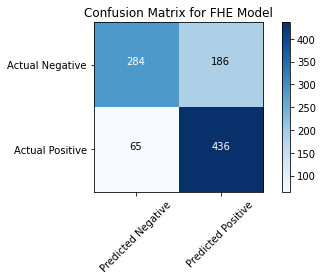

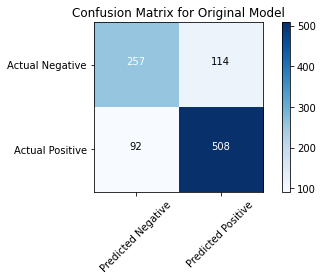

In [137]:
import pandas as pd
import numpy as np
import timeit
import itertools
import matplotlib.pyplot as plt

restaurant_reviews_df = pd.read_csv('restaurant_reviews_updated.csv')

prediction_stats_simulated = [0, 0, 0, 0] 
prediction_stats_original = [0, 0, 0, 0]  
difference_total = 0
time_total = 0

def evaluate(sentence, actual_rating):
    global difference_total, time_total
    
    try:
        embedded = encode(sentence)
    except KeyError as error:
        return

    if embedded.shape[0] > SENTENCE_LENGTH_LIMIT:
        embedded = embedded[:SENTENCE_LENGTH_LIMIT]

    padded = np.zeros((SENTENCE_LENGTH_LIMIT, 300))
    padded[SENTENCE_LENGTH_LIMIT - embedded.shape[0]:, :] = embedded

    simulated = homomorphic_inferer.simulate(padded)[0]
    if simulated < 0.5:
        predicted_sentiment_simulated = 1
    else:
        predicted_sentiment_simulated = 5
    
    start = timeit.default_timer()
    original = model(torch.tensor(padded.reshape((-1, 1, 300))).float()).detach().numpy()[0, 0, 0]
    end = timeit.default_timer()
    
    if original < 0.5:
        predicted_sentiment_original = 1
    else:
        predicted_sentiment_original = 5
    
    if predicted_sentiment_simulated == 1:
        if actual_rating in [1, 2, 3]:
            prediction_stats_simulated[0] += 1  
        else:
            prediction_stats_simulated[1] += 1  
    else:
        if actual_rating in [4, 5]:
            prediction_stats_simulated[2] += 1  
        else:
            prediction_stats_simulated[3] += 1  
    
    if predicted_sentiment_original == 1:
        if actual_rating in [1, 2, 3]:
            prediction_stats_original[0] += 1  
        else:
            prediction_stats_original[1] += 1  
    else:
        if actual_rating in [4, 5]:
            prediction_stats_original[2] += 1  
        else:
            prediction_stats_original[3] += 1  
    
    difference_total += np.abs(original - simulated) * 100
    time_total += end - start
        
for index, row in restaurant_reviews_df.head(2000).iterrows():
    text = row['Review']
    actual_rating = int(row['Rating'])
    
    evaluate(text, actual_rating)

accuracy_rate_simulated = (prediction_stats_simulated[0] + prediction_stats_simulated[2]) / sum(prediction_stats_simulated)
accuracy_rate_original = (prediction_stats_original[0] + prediction_stats_original[2]) / sum(prediction_stats_original)

print(f"Accuracy rate for Simulated Model: {accuracy_rate_simulated * 100:.2f}%")
print(f"Accuracy rate for Original Model: {accuracy_rate_original * 100:.2f}%")

conf_matrix_simulated = np.array([[prediction_stats_simulated[0], prediction_stats_simulated[1]],
                                  [prediction_stats_simulated[3], prediction_stats_simulated[2]]])

conf_matrix_original = np.array([[prediction_stats_original[0], prediction_stats_original[1]],
                                  [prediction_stats_original[3], prediction_stats_original[2]]])

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix_simulated, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for FHE Model')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'], rotation=45)
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
plt.tight_layout()

thresh = conf_matrix_simulated.max() / 2.
for i, j in itertools.product(range(conf_matrix_simulated.shape[0]), range(conf_matrix_simulated.shape[1])):
    plt.text(j, i, format(conf_matrix_simulated[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix_simulated[i, j] > thresh else "black")

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix_original, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Original Model')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'], rotation=45)
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
plt.tight_layout()

thresh = conf_matrix_original.max() / 2.
for i, j in itertools.product(range(conf_matrix_original.shape[0]), range(conf_matrix_original.shape[1])):
    plt.text(j, i, format(conf_matrix_original[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix_original[i, j] > thresh else "black")

plt.show()
